## Семинар 8: "Снижение размерности"

ФИО: Жолковский Евгений Константинович

In [49]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
%matplotlib inline
import sys
from sklearn.metrics import explained_variance_score

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [50]:
X = fetch_olivetti_faces()['data']

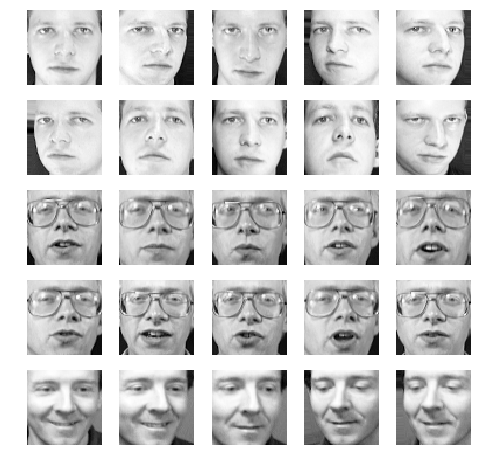

In [51]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [52]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

In [53]:
X.shape

(400, 4096)

In [164]:
model = PCA(n_components=300)
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [165]:
principle_components = model.components_

In [166]:
principle_components.shape

(300, 4096)

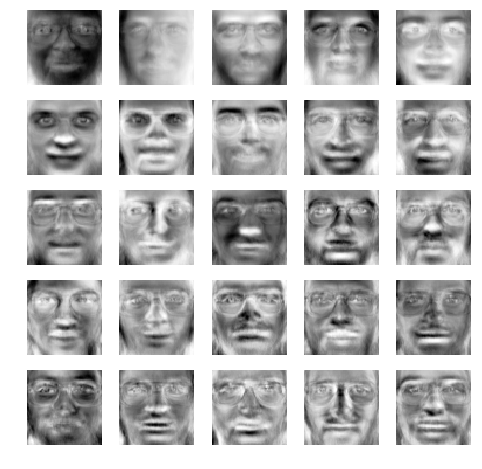

In [167]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(principle_components[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте метод <b>.explained\_variance\_ratio\_</b>

Text(0,0.5,'Reconstruction quality (MSE)')

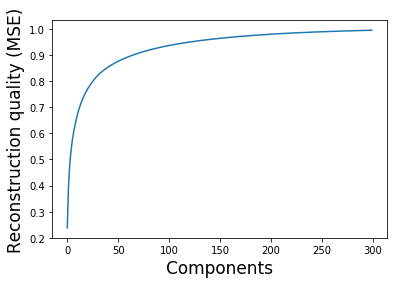

In [168]:
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('Components', fontsize=17)
plt.ylabel('Reconstruction quality (MSE)', fontsize=17)

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

In [177]:
for j, evr in enumerate(np.cumsum(model.explained_variance_ratio_)):
    if evr > 0.95:
        break
print (j)

122


In [59]:
model = PCA(n_components=122)
model.fit(X)
embedding = model.transform(X)
reconstruction = model.inverse_transform(embedding)

Text(0.5,1,'Error')

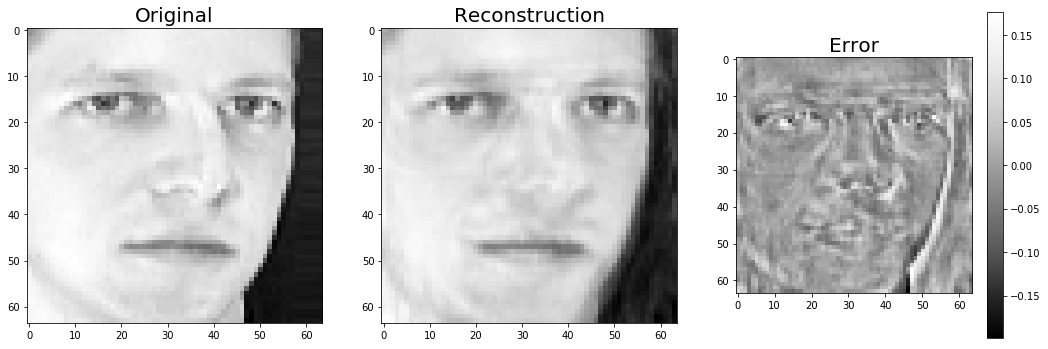

In [60]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow((X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Original', fontsize=20)
plt.subplot(1, 3, 2)
plt.imshow((reconstruction)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Reconstruction', fontsize=20)
plt.subplot(1, 3, 3)
plt.imshow((reconstruction - X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.colorbar()
plt.title('Error', fontsize=20)

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [61]:
model = PCA(n_components=2)
model.fit(X)
embedding = model.transform(X)
reconstruction = model.inverse_transform(embedding)

In [62]:
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in range(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

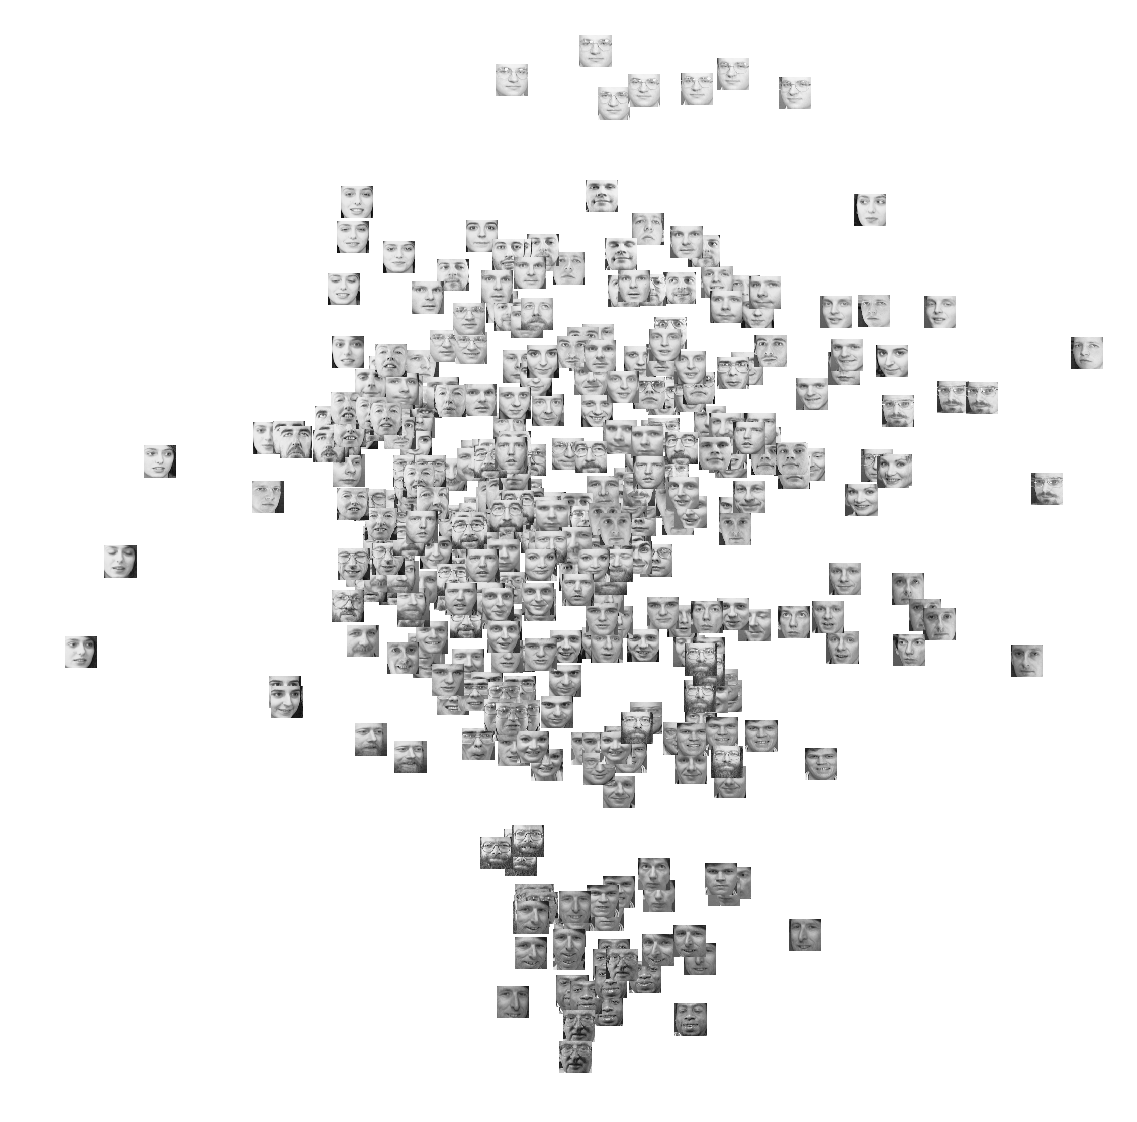

In [63]:
plot_dataset(X, embedding)

Первая компонента — освещение, вторая — в какую сторону смотрит человек

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [64]:
from torch.utils.data import DataLoader, Dataset

In [65]:
dataloader = DataLoader(X, batch_size=400, shuffle=True)

In [66]:
class AE(nn.Module):
    def __init__(self, num):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
                                     nn.BatchNorm1d(4096),
                                     nn.Linear(4096, 200), 
                                     nn.Sigmoid(), 
                                     
                                     nn.BatchNorm1d(200),
                                     nn.Linear(200, num), 
                                     nn.Sigmoid())
        
        self.decoder = nn.Sequential(
                                     nn.BatchNorm1d(num),
                                     nn.Linear(num, 200), 
                                     nn.Sigmoid(),
            
                                     nn.BatchNorm1d(200),
                                     nn.Linear(200, 4096))
        
        nn.init.xavier_normal(self.decoder[1].weight)
        nn.init.xavier_normal(self.decoder[4].weight)

        nn.init.xavier_normal(self.encoder[1].weight)
        nn.init.xavier_normal(self.encoder[4].weight)


    def forward(self, X):
        return self.decoder(self.encoder(X))

In [152]:
def train_model(model, epoch=200, lr=0.01):
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses_ = []
    for epoch in range(epoch):
        losses = []
        for x in dataloader:
            x_batch = Variable(x)
            y_batch = Variable(x, requires_grad=False)
            model.zero_grad()
            x_reconstruction = model(x_batch)
            loss_batch = loss(x_reconstruction, y_batch)
            loss_batch.backward()
            optimizer.step()
            losses.append(loss_batch.data[0])
        sys.stdout.write('\r epoch:{}, {}'.format(epoch, np.mean(losses)))
        losses_.append(np.mean(losses))

##  4096 -> 200 -> 10 -> 200 -> 4096

In [82]:
model10 = AE(10)

In [83]:
model10

AE(
  (encoder): Sequential(
    (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
    (1): Linear(in_features=4096, out_features=200, bias=True)
    (2): Sigmoid()
    (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True)
    (4): Linear(in_features=200, out_features=10, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True)
    (1): Linear(in_features=10, out_features=200, bias=True)
    (2): Sigmoid()
    (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True)
    (4): Linear(in_features=200, out_features=4096, bias=True)
  )
)

In [127]:
train_model(model10, epoch=1)

 0.0050394698046147825

<i> 2.2 Какое качество восстановления удалось получить?</i>

In [119]:
embedding = model10.encoder(Variable(torch.Tensor(X))).data.numpy()
reconstruction = model10.decoder(Variable(torch.Tensor(embedding))).data.numpy()

Text(0.5,1,'Error')

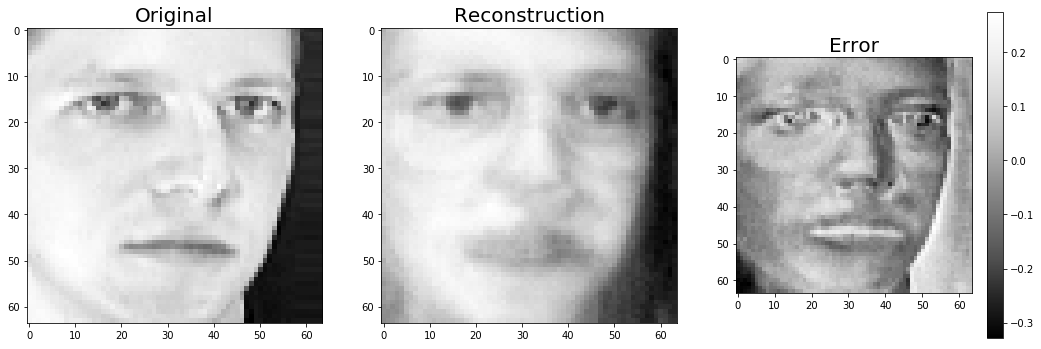

In [120]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow((X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Original', fontsize=20)
plt.subplot(1, 3, 2)
plt.imshow((reconstruction)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Reconstruction', fontsize=20)
plt.subplot(1, 3, 3)
plt.imshow((reconstruction - X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.colorbar()
plt.title('Error', fontsize=20)

##  4096 -> 200 -> 100 -> 200 -> 4096

In [696]:
model100 = AE(100)
train_model(model100)

 0.008158493787050247

In [697]:
embedding = model100.encoder(Variable(torch.Tensor(X))).data.numpy()
reconstruction = model100.decoder(Variable(torch.Tensor(embedding))).data.numpy()

Text(0.5,1,'Error')

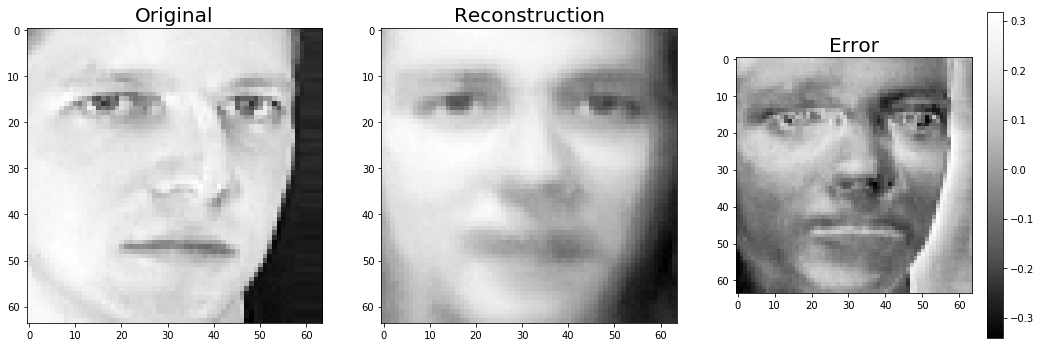

In [698]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow((X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Original', fontsize=20)
plt.subplot(1, 3, 2)
plt.imshow((reconstruction)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.title('Reconstruction', fontsize=20)
plt.subplot(1, 3, 3)
plt.imshow((reconstruction - X)[1].reshape(64, 64), cmap=plt.cm.Greys_r)
plt.colorbar()
plt.title('Error', fontsize=20)

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [150]:
def evrs(sizes):
    evrs_ = np.zeros(len(sizes))
    
    for j, num in enumerate(sizes):
        print ('\n' ,j, num, ':')
        model = AE(num)
        train_model(model, epoch=200)
        
        embedding = model.encoder(Variable(torch.Tensor(X))).data.numpy()
        reconstruction = model.decoder(Variable(torch.Tensor(embedding))).data.numpy()
        
        err2 = ((reconstruction-X)**2).sum(1).mean()
        evr = 1 - err2 / (X**2).sum(1).mean()
        
        evrs_[j] = evr
    
    return evrs_

In [151]:
nums = [1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]
variances = evrs(nums)
variances


 0 1 :
 epoch:199, 0.014664538204669952
 1 3 :
 epoch:199, 0.010372801683843136
 2 6 :
 epoch:199, 0.008255260065197945
 3 10 :
 epoch:199, 0.0072218603454530245
 4 30 :
 epoch:199, 0.0050052120350301276
 5 60 :
 epoch:199, 0.0037389602512121226
 6 100 :
 epoch:199, 0.0039044779259711504
 7 300 :
 epoch:199, 0.0037099907640367746
 8 600 :
 epoch:199, 0.0047108526341617114
 9 1000 :
 epoch:199, 0.0059663574211299425

array([ 0.95537638,  0.96845686,  0.97489282,  0.97804262,  0.98477094,
        0.98870178,  0.98815082,  0.98868223,  0.98573551,  0.98198381])

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

Text(0,0.5,'EVR')

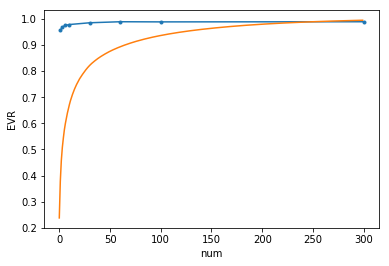

In [174]:
plt.plot(nums[:-2], variances[:-2], marker='.')
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('num')
plt.ylabel('EVR')

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [138]:
model2 = AE(2)

In [139]:
train_model(model2)

 epoch:199, 0.012385618872940549

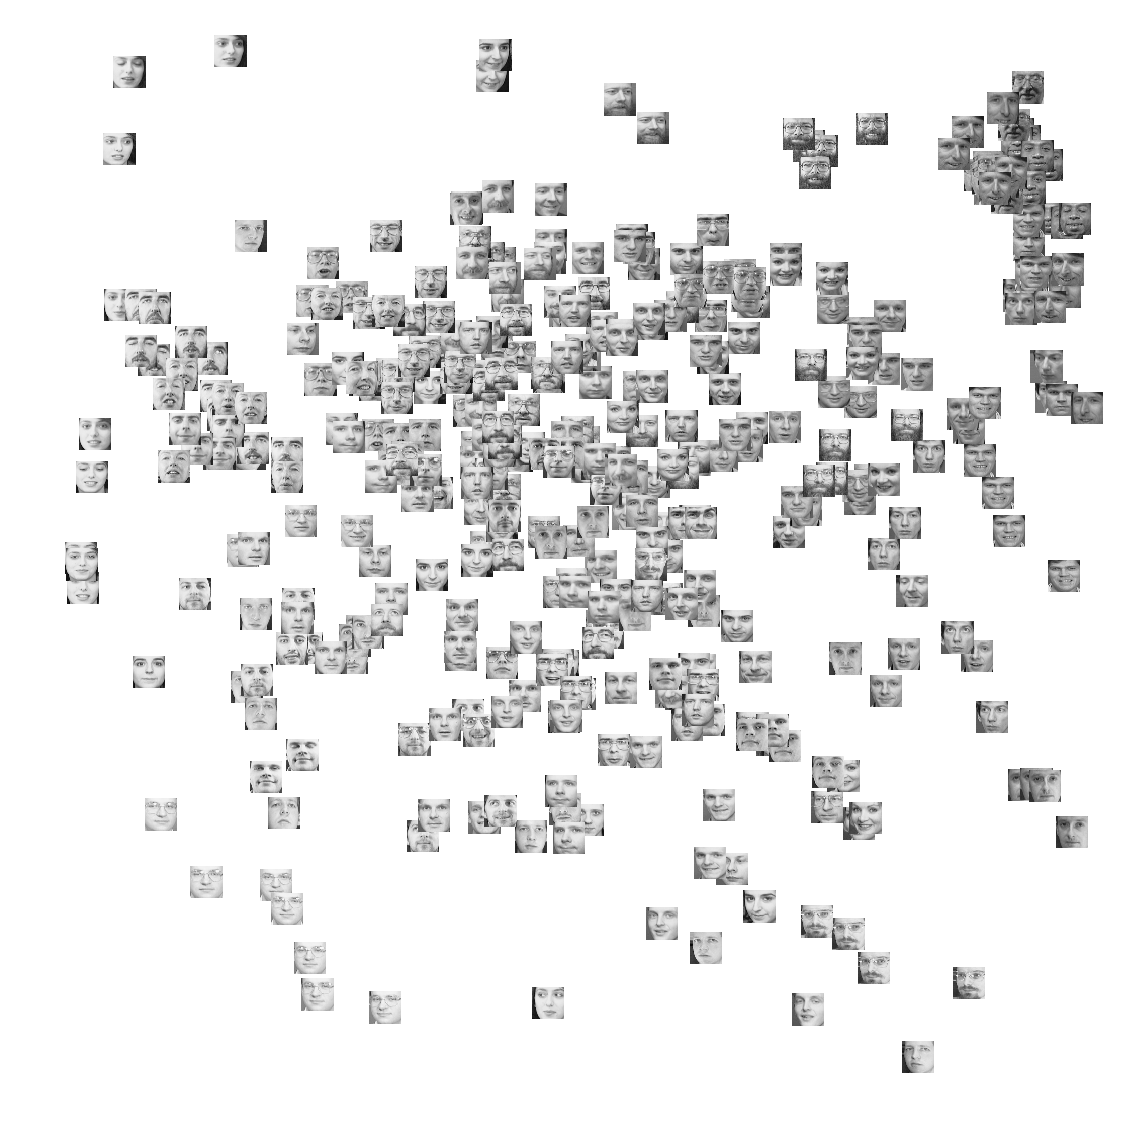

In [694]:
embedding = model2.encoder(Variable(torch.Tensor(X))).data.numpy()
plot_dataset(X, embedding)

Изображения сгрупировались по освещению, выделились кластеры из фотографий одного человека